In [75]:
# 1. Environment and Imports

# Library and sci-kit learn model imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Tensorflow import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Torch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Statistical test
from scipy.stats import wilcoxon

In [2]:
# Load the dataset
df = pd.read_csv('La_Liga_Dataset.csv', parse_dates = ['date'])
df.head(5)

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,0,2024-08-17,21:30,La Liga,Matchweek 1,Sat,Away,W,2.0,1.0,...,Match Report,NaN,17.0,5.0,18.6,1.0,1,1,2025,Barcelona
1,1,2024-08-24,19:00,La Liga,Matchweek 2,Sat,Home,W,2.0,1.0,...,Match Report,NaN,13.0,5.0,16.6,0.0,0,0,2025,Barcelona
2,2,2024-08-27,21:30,La Liga,Matchweek 3,Tue,Away,W,2.0,1.0,...,Match Report,NaN,22.0,5.0,19.3,1.0,0,0,2025,Barcelona
3,3,2024-08-31,17:00,La Liga,Matchweek 4,Sat,Home,W,7.0,0.0,...,Match Report,NaN,23.0,11.0,13.7,1.0,0,0,2025,Barcelona
4,4,2024-09-15,16:15,La Liga,Matchweek 5,Sun,Away,W,4.0,1.0,...,Match Report,NaN,20.0,9.0,19.1,0.0,0,0,2025,Barcelona


In [3]:
# Remove unecessary columns and review to make sure its removed
drop_cols = ["pk","pkatt","dist","fk","notes","referee",
             "opp formation","comp","captain","match report","Unnamed: 0"]
df = df.drop(columns=drop_cols, errors="ignore")
df.head(5)

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,formation,sh,sot,season,team
0,2024-08-17,21:30,Matchweek 1,Sat,Away,W,2.0,1.0,Valencia,3.2,1.0,63.0,46673.0,4-2-3-1,17.0,5.0,2025,Barcelona
1,2024-08-24,19:00,Matchweek 2,Sat,Home,W,2.0,1.0,Athletic Club,1.8,1.0,64.0,46448.0,4-2-3-1,13.0,5.0,2025,Barcelona
2,2024-08-27,21:30,Matchweek 3,Tue,Away,W,2.0,1.0,Rayo Vallecano,1.4,0.4,64.0,14031.0,4-2-3-1,22.0,5.0,2025,Barcelona
3,2024-08-31,17:00,Matchweek 4,Sat,Home,W,7.0,0.0,Valladolid,4.7,0.5,70.0,44359.0,4-3-3,23.0,11.0,2025,Barcelona
4,2024-09-15,16:15,Matchweek 5,Sun,Away,W,4.0,1.0,Girona,1.9,1.3,55.0,13891.0,4-2-3-1,20.0,9.0,2025,Barcelona


In [4]:
# Season and Match Number
df['season'] = np.where(df['date'].dt.month >= 8,
                        df['date'].dt.year,
                        df['date'].dt.year - 1)
df = df.sort_values(['team', 'season', 'date']).reset_index(drop=True)
df['round'] = df.groupby(['team', 'season']).cumcount() + 1

In [5]:
# Basic Features
df["GD"] = df["gf"] - df["ga"]
df["points"] = np.select([df["result"]=="W", df["result"]=="D"], [3,1],
                         default=0)
df["shot_accuracy"] = df["sot"]/df["sh"]
df["possession_percentage"] = df["poss"].astype(float)/100

In [6]:
# 4) Count matches per season for later per-match rates
matches = df.groupby(["team","season"]).size().rename("matches_played")
df = df.join(matches, on=["team","season"])

In [7]:
print(df.columns.tolist())

['date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'formation', 'sh', 'sot', 'season', 'team', 'GD', 'points', 'shot_accuracy', 'possession_percentage', 'matches_played']


In [8]:
# First half of the season (Matchweeks 1 to 19)
first_half = df[df["round"] <= 19].groupby(["team","season"]).agg({
    "points": "sum",
    "GD": "sum",
    "xg": "mean",
    "xga": "mean",
    "possession_percentage": "mean",
    "shot_accuracy": "mean"
}).add_suffix("_first_half").reset_index()

In [9]:
# Target table by shifting season -1
first_half_target = first_half.copy()
first_half_target["season"] = first_half_target["season"] - 1
first_half_target = first_half_target.rename(columns={
    "points_first_half": "points_next_half",
    "GD_first_half": "GD_next_half",
    "xg_first_half": "xg_next_half",
    "xga_first_half": "xga_next_half",
    "possession_percentage_first_half": "possession_percentage_next_half",
    "shot_accuracy_first_half": "shot_accuracy_next_half"
})

In [10]:
# Merge features (season N) with target (season N+1)
data = first_half.merge(
    first_half_target[["team","season","points_next_half"]],
    on=["team","season"],
    how="inner"
)

In [11]:
print(data.head())

            team  season  points_first_half  GD_first_half  xg_first_half  \
0         Alaves    2019                 20           -9.0       1.100000   
1         Alaves    2020                 18           -8.0       1.184211   
2         Alaves    2023                 17          -10.0       1.205263   
3        Almeria    2022                 22           -6.0       1.126316   
4  Athletic Club    2019                 29            7.0       0.994737   

   xga_first_half  possession_percentage_first_half  shot_accuracy_first_half  \
0        1.589474                          0.423684                  0.281217   
1        1.373684                          0.420000                  0.287697   
2        1.152632                          0.426842                  0.258255   
3        1.573684                          0.463158                  0.337486   
4        1.047368                          0.475789                  0.335229   

   points_next_half  
0                18  
1     

### **2. Train / Val / Test Split**

In [30]:
# now using season end‐years:
# 2020 (19/20), 2021 (20/21), 2022 (21/22) → train
# 2023 (22/23) → val
# 2024 (23/24) → test/back‐test

train = data[data["season"] < 2022]
val   = data[data["season"] == 2022]
test  = data[data["season"] == 2023]

feature_columns = [c for c in data.columns if c.endswith("_first_half")]
target_column   = "points_next_half"

x_train, y_train = train[feature_columns], train[target_column]
x_val,   y_val   = val[feature_columns],   val[target_column]
x_test,  y_test  = test[feature_columns],  test[target_column]

### **3. Linear Regression**

In [31]:
# Train the model
linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)

# Predict on the validation set
y_pred_lr = linear_regression.predict(x_val)
mae_val_lr = mean_absolute_error(y_val, y_pred_lr)
rmse_val_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
print(f"Validation MAE (Linear Regression): {mae_val_lr:.2f}")
print(f"Validation RMSE (Linear Regression): {rmse_val_lr:.2f}")

Validation MAE (Linear Regression): 7.07
Validation RMSE (Linear Regression): 9.00


In [32]:
print("Available seasons in cross‐season table:", sorted(data["season"].unique()))

Available seasons in cross‐season table: [np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]


In [33]:
# Back-test
pred_test_lr = linear_regression.predict(x_test)
mae_val_lr = mean_absolute_error(y_test, pred_test_lr)
rmse_val_lr = np.sqrt(mean_squared_error(y_test, pred_test_lr))
print(f"Test MAE (Linear Regression): {mae_val_lr:.2f}")
print(f"Test RMSE (Linear Regression): {rmse_val_lr:.2f}")

Test MAE (Linear Regression): 5.29
Test RMSE (Linear Regression): 6.92


### **4. Random Forest**

In [34]:
# Import RandomForest
from sklearn.ensemble import RandomForestRegressor

In [35]:
# Train the model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=200, n_jobs=-1, random_state=42)

In [36]:
# Predict on validation set
pred_val_rf = rf.predict(x_val)
mae_val_rf = mean_absolute_error(y_val, pred_val_rf)
rmse_val_rf = np.sqrt(mean_squared_error(y_val, pred_val_rf))
print(f"Validation MAE (Random Forest): {mae_val_rf:.2f}")
print(f"Validation RMSE (Random Forest): {rmse_val_rf:.2f}")

# Back-test
pred_test_lr = rf.predict(x_test)
mae_val_lr = mean_absolute_error(y_test, pred_test_lr)
rmse_val_lr = np.sqrt(mean_squared_error(y_test, pred_test_lr))
print(f"Test MAE (Random Forest): {mae_val_lr:.2f}")
print(f"Test RMSE (Random Forest): {rmse_val_lr:.2f}")

Validation MAE (Random Forest): 6.86
Validation RMSE (Random Forest): 9.53
Test MAE (Random Forest): 4.61
Test RMSE (Random Forest): 5.98


In [37]:
# Feature importances
feature_importances = pd.Series(rf.feature_importances_, index=feature_columns)
print("Top Features:\n",feature_importances.sort_values(ascending=False).head(10))

Top Features:
 xg_first_half                       0.337802
points_first_half                   0.216616
possession_percentage_first_half    0.183194
GD_first_half                       0.123402
shot_accuracy_first_half            0.076169
xga_first_half                      0.062818
dtype: float64


### **5. Hyperparameter Tuning (RandomizedSearchCV + TimeSeriesSplit)**

In [38]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Build feature matrix and target (for only complete pairs)
x_all = data[feature_columns]
y_all = data[target_column]

# Hyperparamater grid
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [39]:
# Time-series CV: split seasons in order
tss = TimeSeriesSplit(n_splits=4)

# Randomized Search
rscv = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=tss,
    scoring="neg_mean_absolute_error",
    refit=True,     # automatically refits on all with best parameters
    random_state=42,
    verbose=1
)

# Run the search
rscv.fit(x_all, y_all)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=20,
                   param_distributions={'max_depth': [3, 5, 8, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [40]:
# Best found hyperparameters & CV score
print("Best Parameters:", rscv.best_params_)
print("Best CV Score:", rscv.best_score_)

# My tuned RandomForest, already refit on all x_all/y_all
best_rf = rscv.best_estimator_

# Quick evaluation on hold-out test-split
pred_test_rf = best_rf.predict(x_test)
print("Tuned RF Test MAE:", mean_absolute_error(y_test, pred_test_rf))
print("Tuned RF Test RMSE:", np.sqrt(mean_squared_error(y_test, pred_test_rf)))

Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 8}
Best CV Score: -5.477090818896121
Tuned RF Test MAE: 2.7592863279742215
Tuned RF Test RMSE: 3.697748401646293


### **6. TensorFlow/Keras Multi-Layer Perceptron (MLP)**


In [41]:
# To turn (x, y) into a tf.data.Dataset
def ds_from(x,y, batch_size = 8, shuffle=False):
  ds = tf.data.Dataset.from_tensor_slices((
      tf.cast(x.values, tf.float32),
      tf.cast(y.values, tf.float32)
  ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(x))
  return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [42]:
# Build train/val/test datasets
train_ds = ds_from(x_train, y_train, shuffle=True)
val_ds = ds_from(x_val, y_val, shuffle=False)
test_ds = ds_from(x_test, y_test, shuffle=False)

In [43]:
# Define the Multi-Layer Perceptron
tf_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(feature_columns),)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1), #linear output for regression
])

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [44]:
# Train and validate
history = tf_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=2
)

Epoch 1/30
7/7 - 1s - 144ms/step - loss: 1017.5253 - mean_absolute_error: 30.1243 - val_loss: 943.0721 - val_mean_absolute_error: 28.4214
Epoch 2/30
7/7 - 0s - 13ms/step - loss: 807.0626 - mean_absolute_error: 26.9045 - val_loss: 742.7972 - val_mean_absolute_error: 25.1254
Epoch 3/30
7/7 - 0s - 3ms/step - loss: 634.9581 - mean_absolute_error: 23.7488 - val_loss: 599.9825 - val_mean_absolute_error: 22.3677
Epoch 4/30
7/7 - 0s - 2ms/step - loss: 507.8018 - mean_absolute_error: 21.1971 - val_loss: 497.0086 - val_mean_absolute_error: 20.0507
Epoch 5/30
7/7 - 0s - 2ms/step - loss: 419.5465 - mean_absolute_error: 19.0635 - val_loss: 415.4214 - val_mean_absolute_error: 17.9868
Epoch 6/30
7/7 - 0s - 3ms/step - loss: 349.3257 - mean_absolute_error: 17.1303 - val_loss: 349.2032 - val_mean_absolute_error: 16.2678
Epoch 7/30
7/7 - 0s - 3ms/step - loss: 281.9480 - mean_absolute_error: 15.1987 - val_loss: 281.0627 - val_mean_absolute_error: 14.2598
Epoch 8/30
7/7 - 0s - 3ms/step - loss: 218.1746 - m

In [45]:
# Evaluate on test split
mse_te, mae_te = tf_model.evaluate(test_ds, verbose=0)
print(f"TensorFlow Test MSE: {mse_te:.2f}")
print(f"TensorFlow Test MAE: {mae_te:.2f}")

TensorFlow Test MSE: 50.88
TensorFlow Test MAE: 5.44


In [70]:
# Pull the 2024/25 first‐half features (season == 2024)
H1_24_25 = first_half[first_half["season"] == 2024][feature_columns]
teams  = first_half[first_half["season"] == 2024]["team"].values


# RandomForest Forecast
rf_preds_25_26 = best_rf.predict(H1_24_25)

# Convert to a tf.data.Dataset for prediction
ds_2024 = tf.data.Dataset.from_tensor_slices(
      tf.cast(H1_24_25.values, tf.float32)
    ).batch(8)

# Predict
tf_preds_25_26 = tf_model.predict(ds_2024).flatten()

# Assemble into a Dataframe
forecast_2025_26 = pd.DataFrame({
        "team": teams,
        "rf_points_25_26_H1": np.round(rf_preds_25_26, 1),
        "tf_points_25_26_H1": np.round(tf_preds_25_26, 1),
    })

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### **7. Offline A/B Testing**

In [65]:
# Actual 24/25 first-half points (season == 2024)
actual = first_half.loc[
    first_half["season"] == 2024,
    ["team","points_first_half"]
].rename(columns={"points_first_half": "actual_points"})

In [66]:
# Merge actuals and forecasts for A/B testing
eval_df = actual.merge(forecast_2025_26, on="team", how="inner")

# Compute errors on the first half of the 24/25 season hold-out
eval_df["rf_error"] = np.abs(eval_df["rf_points_25_26_H1"] - eval_df["actual_points"])
eval_df["tf_error"] = np.abs(eval_df["tf_points_25_26_H1"] - eval_df["actual_points"])

In [67]:
# Print Mean Absolute Errors
print("RF MAE on 2024/25 first-half of season:", mean_absolute_error(eval_df["actual_points"], eval_df["rf_points_25_26_H1"]))
print("TF MAE on 2024/25 first-half of season:", mean_absolute_error(eval_df["actual_points"], eval_df["tf_points_25_26_H1"]))

RF MAE on 2024/25 first-half of season: 3.3
TF MAE on 2024/25 first-half of season: 2.3399999141693115


In [68]:
# Paired Wilcoxon test
stat, p = wilcoxon(eval_df["rf_error"], eval_df["tf_error"])
print(f"RF vs TF MAE p-value: {p:.3f}")

RF vs TF MAE p-value: 0.006


In [74]:
# Final 2025/26 first half of the season forecast (tf_points)
print("\nForecast for the first-half of the 2025/26 season (tf_points):")
print(
    forecast_2025_26
      .sort_values("tf_points_25_26_H1", ascending=False)
      .reset_index(drop=True)
)


Forecast for the first-half of the 2025/26 season (tf_points):
               team  rf_points_25_26_H1  tf_points_25_26_H1
0   Atletico Madrid                40.2           40.400002
1       Real Madrid                39.6           40.200001
2         Barcelona                37.3           37.500000
3     Athletic Club                31.0           33.099998
4        Villarreal                33.0           27.700001
5          Mallorca                22.8           27.100000
6     Real Sociedad                25.6           26.000000
7            Girona                25.8           25.900000
8        Valladolid                17.5           23.900000
9        Real Betis                30.0           23.200001
10   Rayo Vallecano                23.0           23.200001
11          Osasuna                22.0           23.000000
12       Celta Vigo                26.9           22.200001
13          Sevilla                21.2           21.900000
14       Las Palmas                1

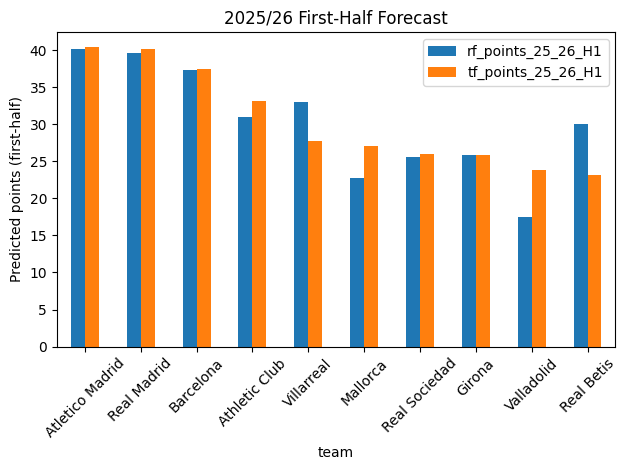

In [77]:
# Forecast Bar Chart
top10 = forecast_2025_26.sort_values("tf_points_25_26_H1", ascending=False).head(10)
top10.plot.bar(x="team", y=["rf_points_25_26_H1", "tf_points_25_26_H1"], rot=45)
plt.ylabel("Predicted points (first-half)")
plt.title("2025/26 First-Half Forecast")
plt.tight_layout()
plt.show()

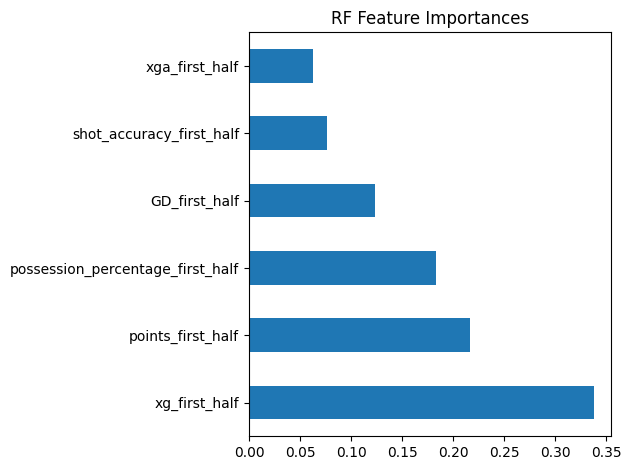

In [79]:
# Feature importances from tuned RandomForest
feature_importances = pd.Series(rf.feature_importances_, index=feature_columns)
feature_importances.sort_values(ascending=False).plot.barh()
plt.title("RF Feature Importances")
plt.tight_layout()
plt.show()